In [ ]:
!pip install tensorflowjs
!pip install TensorFlow==2.15.0
!pip install tensorflow-decision-forests==1.8.1

ERROR: Operation cancelled by user
  Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
  Using cached ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached wrapt-1.14.1-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 475.2/475.2 MB 157.5 MB/s eta 0:00:01
ERROR: Operation cancelled by user
^C
  Using cached tensorflow_decision_forests-1.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.0 kB)
  Using cached tensorflow-2.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached ml_dtypes-0.3.2-cp3

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/HIRA")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input
from sklearn.metrics import balanced_accuracy_score
import tensorflow as tf
import tensorflow.keras.backend as K

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.6 MB/s eta 0:00:00


In [ ]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Attention, Bidirectional, BatchNormalization
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Load dataset
df = pd.read_csv('df3.csv')
MAX_LEN = 20
# Text and labels
X = df['Text']
y = df.drop(columns='Text')

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
vocab_size = len(tokenizer.word_index) + 1
max_length = MAX_LEN
X_padded = pad_sequences(X_seq, maxlen=max_length, padding='post')

# Save tokenizer to a file
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Custom F1-score metric
def f1_score_metric(y_true, y_pred):
    # Cast y_true to float32
    y_true = K.cast(y_true, K.floatx())  # Cast y_true to float32
    y_pred = K.cast(K.greater(y_pred, 0.5), K.floatx())
    tp = K.sum(y_true * y_pred)
    fp = K.sum(K.cast(K.greater(y_pred, 0.5), K.floatx()) - tp)
    fn = K.sum(y_true - tp)
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

tf.keras.backend.clear_session()

# Build model
model = Sequential([
    # Input layer
    Input(shape=(MAX_LEN,), name="input_layer"),

    # Embedding layer
    Embedding(input_dim=vocab_size, output_dim=64, name="embedding_layer"),

    # Bidirectional LSTM layers with batch normalization
    Bidirectional(LSTM(32, return_sequences=True), name="bidirectional_lstm_1"),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(16, return_sequences=False), name="bidirectional_lstm_2"),
    BatchNormalization(),
    Dropout(0.3),

    # Dense layers for learning
    Dense(32, activation='relu', name="dense_1"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(8, activation='relu', name="regulizer"),
    Dense(16, activation='relu', name="dense_2"),

    # Output layer (sigmoid for binary classification or softmax for multi-class)
    Dense(y.shape[1], activation='softmax', name="dense_3")  # Assuming multi-class classification
])


# Compile model
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])

# Train model
history = model.fit(
    X_train, y_train,
    epochs=1300,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1,
)

# Save the model
model.save('multi_label_model.h5')
print("Training complete. Model saved to 'multi_label_model.h5'.")


Epoch 1/1300
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.0831 - f1_score_metric: 0.0000e+00 - loss: 0.7389 - val_accuracy: 0.0380 - val_f1_score_metric: 0.0000e+00 - val_loss: 0.6909
Epoch 2/1300
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.0870 - f1_score_metric: 0.0000e+00 - loss: 0.7238 - val_accuracy: 0.0380 - val_f1_score_metric: 0.0000e+00 - val_loss: 0.6870
Epoch 3/1300
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.0935 - f1_score_metric: 0.0000e+00 - loss: 0.6974 - val_accuracy: 0.0380 - val_f1_score_metric: 0.0000e+00 - val_loss: 0.6823
Epoch 4/1300
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1139 - f1_score_metric: -1.9131e-04 - loss: 0.6867 - val_accuracy: 0.0380 - val_f1_score_metric: 0.0000e+00 - val_loss: 0.6748
Epoch 5/1300
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1148 - f1_score_metric: 0.0000e+00 - loss: 0.6772 - val_accuracy: 0.0380 - val_f1_score_metric: 0.0000e+00 - val_loss: 0.6645
Epoch 6/1300
46/46 ━━━━━━━━━━━━━━

Training complete. Model saved to 'multi_label_model.h5'.


In [ ]:
!tensorflowjs_converter --input_format keras multi_label_model.h5 tfjs_model/

2024-12-12 08:30:16.460759: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 08:30:16.460826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 08:30:16.462905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 08:30:17.944696: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
import pickle
import json

# Load the tokenizer from the .pkl file
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Extract the word index from the tokenizer
vocab = tokenizer.word_index

# Save the word index as a JSON file
with open('tokenizer_vocab.json', 'w') as json_file:
    json.dump(vocab, json_file)

print("Vocabulary saved as 'tokenizer_vocab.json'.")


Vocabulary saved as 'tokenizer_vocab.json'.


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding  (None, 20, 64)            6400      
 )                                                               
                                                                 
 bidirectional_lstm_1 (Bidi  (None, 20, 64)            24832     
 rectional)                                                      
                                                                 
 batch_normalization (Batch  (None, 20, 64)            256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 bidirectional_lstm_2 (Bidi  (None, 32)                10368     
 rectional)                                             

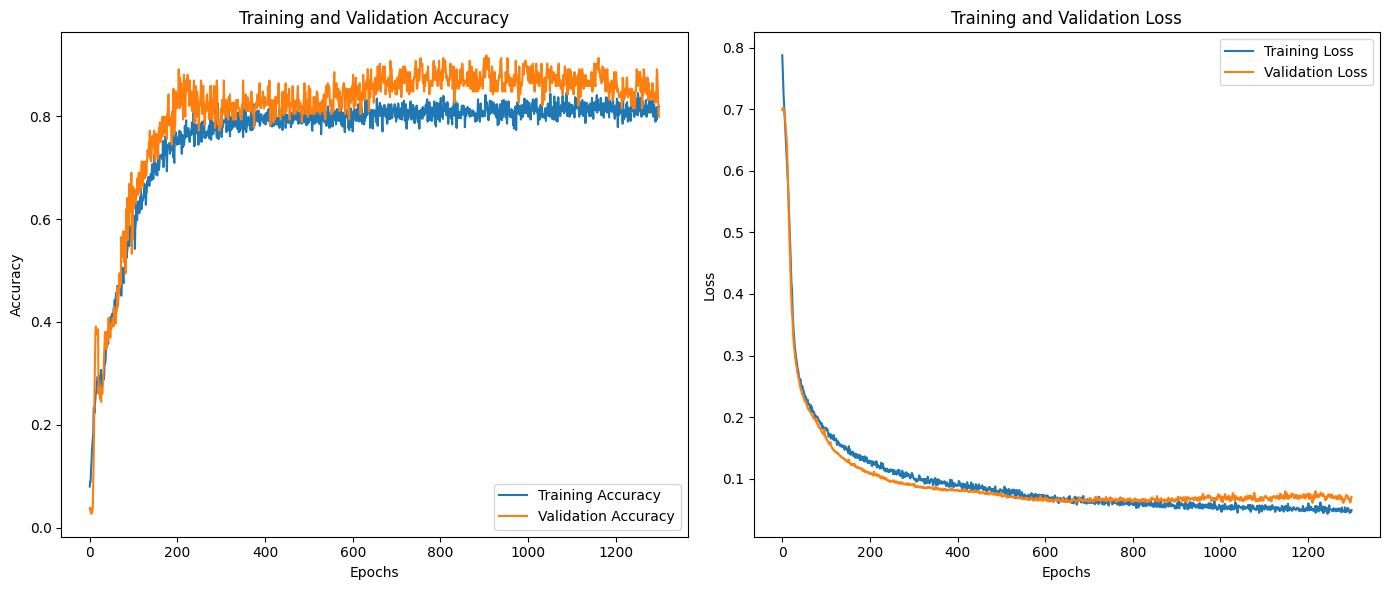

In [ ]:
# Plot training/validation accuracy and balanced accuracy per epoch
import matplotlib.pyplot as plt

# Training history
history_dict = history.history

# Plot accuracy and balanced accuracy per epoch
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy
ax[0].plot(history_dict['accuracy'], label='Training Accuracy')
ax[0].plot(history_dict['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Loss
ax[1].plot(history_dict['loss'], label='Training Loss')
ax[1].plot(history_dict['val_loss'], label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()


Predict

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Fungsi untuk memproses teks input
def preprocess_text(text, tokenizer, max_length=MAX_LEN):
    """
    Preprocess a single text input for prediction.

    Args:
        text (str): Input text to preprocess.
        tokenizer (Tokenizer): Pre-trained tokenizer used for the model.
        max_length (int): Maximum sequence length for padding.

    Returns:
        numpy.array: Padded and tokenized sequence ready for model input.
    """
    seq = tokenizer.texts_to_sequences([text])  # Tokenize the text
    padded = pad_sequences(seq, maxlen=max_length, padding='post')  # Pad the sequence
    return padded


# Fungsi untuk melakukan prediksi
def predict(text, model, tokenizer, label_columns, max_length=MAX_LEN):
    """
    Predict labels for a given text using the trained model.

    Args:
        text (str): Input text for prediction.
        model (tf.keras.Model): Trained Keras model.
        tokenizer (Tokenizer): Pre-trained tokenizer used for the model.
        label_columns (list): List of label names.
        max_length (int): Maximum sequence length for padding.

    Returns:
        list: List of predicted labels.
    """
    # Preprocess the input text
    processed_text = preprocess_text(text, tokenizer, max_length)

    # Perform prediction
    predictions = model.predict(processed_text, verbose=0)  # Suppress verbose output

    # Convert probabilities to labels based on threshold
    threshold = 0.5  # Adjust as necessary
    predicted_labels = [label_columns[i] for i, pred in enumerate(predictions[0]) if pred > threshold]

    return predicted_labels


# Contoh penggunaan
new_text = "saya ingin kopi gula aren."
predicted_labels = predict(new_text, model, tokenizer, y.columns.tolist(), max_length=MAX_LEN)

print(f"Teks: {new_text}")
print(f"Prediksi Label: {predicted_labels}")


Teks: saya ingin kopi gula aren.
Prediksi Label: ['Gula Aren(Ice)', 'Coffee Latte(Ice)']
